The Methods that I will try: 
1. LSTM
2. GRU
3. RF
4. Prophet
5. RNN
6. GBM

In [57]:
import pandas as pd
import numpy as np

In [68]:
df= pd.read_csv('EDA_weather/model_input.csv',delimiter=';')
df.drop(['location'],axis=1,inplace=True)
# remove instances where lceq_avg is 0
df = df[df['lceq_avg'] != 0]

In [58]:
# split into training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop(['lceq_avg','lcpeak_avg'],axis=1), df['lcpeak_avg'], test_size=0.2, random_state=40)

### Random Forest Implementation with hyperparameter tuning using random search ---- Test R2 score:  0.8826292629716137

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# find the best hyperparameters for the Random Forest using RandomizedSearchCV
# n_estimators = number of trees in the forest
# max_features = number of features to consider at every split
# max_depth = maximum number of levels in each tree
# min_samples_split = minimum number of samples required to split a node
# min_samples_leaf = minimum number of samples required at each leaf node
# bootstrap = method of selecting samples for training each tree

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=1, random_state=42, n_jobs = -1)

rf_random.fit(x_train, y_train)

In [16]:
# show the best parameters
rf_random.best_params_

{'n_estimators': 890,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [60]:
# create a tree using the best parameters
rf = RandomForestRegressor(n_estimators= 890,
    min_samples_split= 5,
    min_samples_leaf= 1,
    max_features= 'sqrt',
    max_depth= 80,
    bootstrap= False)

In [ ]:
# import r2score
from sklearn.metrics import r2_score
rf.fit(x_train,y_train)
Rf_train_pred = rf.predict(x_train)
Rf_test_pred = rf.predict(x_test)

r2_score(y_test,Rf_test_pred)

In [63]:
# show metrics scores for the decision tree model
print('Random Forest')
print('Train R2 score: ',r2_score(y_train,Rf_train_pred))
print('Test R2 score: ',r2_score(y_test,Rf_test_pred))
print('Train RMSE score: ',np.sqrt(mean_squared_error(y_train,Rf_train_pred)))
print('Test RMSE score: ',np.sqrt(mean_squared_error(y_test,Rf_test_pred)))

Random Forest
Train R2 score:  0.9906077882250667
Test R2 score:  0.8826292629716137
Train RMSE score:  0.5502775355013841
Test RMSE score:  1.9546686559854591


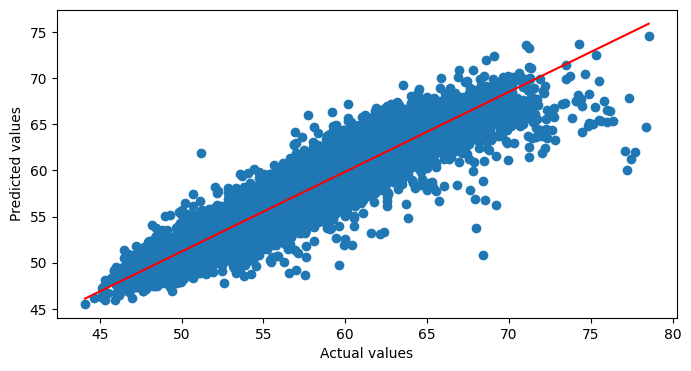

In [64]:
import matplotlib.pyplot as plt
# create a scatterplot of the predicted values vs the actual values
plt.rcParams['figure.figsize'] = [8,4]
plt.scatter(y_test,Rf_test_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# add the line of best fit
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, Rf_test_pred, 1))(np.unique(y_test)),color='red')
plt.show()

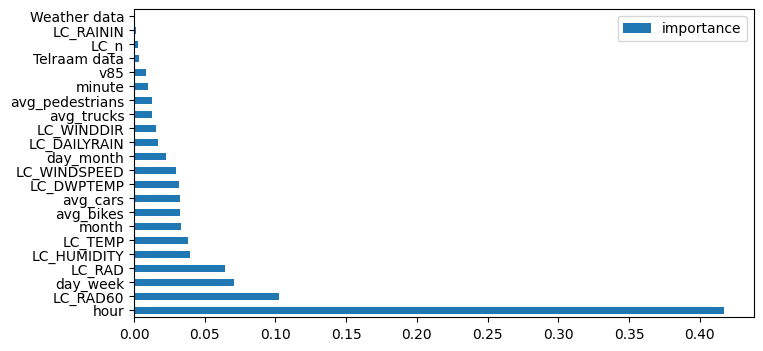

In [66]:
# show feature importance in a horizontal bar chart
feature_importances = pd.DataFrame(rf.feature_importances_,index = x_train.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot(kind='barh')
plt.show()

Some features are irrelevant, removing may help with the overfitting problem

In [ ]:
df_reduced = df.drop(['LC_RAININ','LC_n','v85'])

### Extreme Gradient Boosting Implementation without hyperparameter tuning --- Test R2 score:  0.8918867960864459

XGBoost
Train R2 score:  0.9761471497479626
Test R2 score:  0.8918867960864459
Train RMSE score:  0.8720796903488381
Test RMSE score:  1.8652162851391338


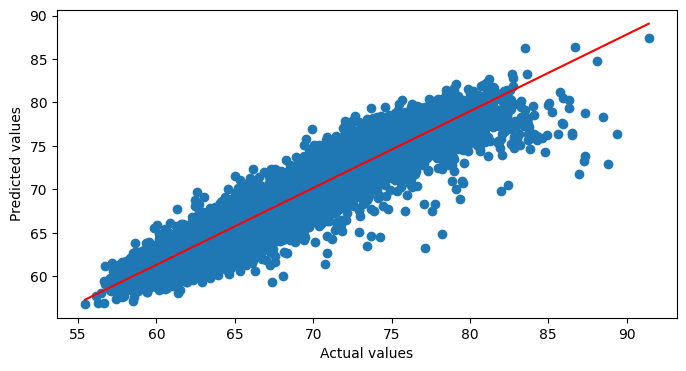

In [8]:
# import libraries for xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# create a xgboost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 1000)

# fit the model
xg_reg.fit(x_train,y_train)

# predict the values
xgb_train_pred = xg_reg.predict(x_train)
xgb_test_pred = xg_reg.predict(x_test)

# show metrics scores for the xgboost model
from sklearn.metrics import r2_score
print('XGBoost')
print('Train R2 score: ',r2_score(y_train,xgb_train_pred))
print('Test R2 score: ',r2_score(y_test,xgb_test_pred))
print('Train RMSE score: ',np.sqrt(mean_squared_error(y_train,xgb_train_pred)))
print('Test RMSE score: ',np.sqrt(mean_squared_error(y_test,xgb_test_pred)))

# create a scatterplot of the predicted values vs the actual values
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,4]
plt.scatter(y_test,xgb_test_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# add the line of best fit
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, xgb_test_pred, 1))(np.unique(y_test)),color='red')
plt.show()

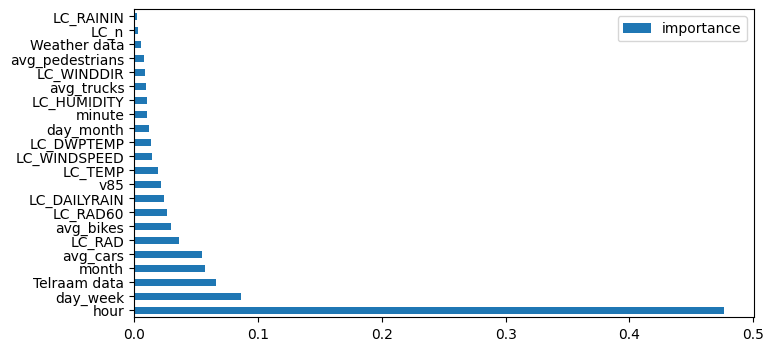

In [9]:
# show feature importance in a horizontal bar chart
feature_importances = pd.DataFrame(xg_reg.feature_importances_,index = x_train.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot(kind='barh')
plt.show()

Repeating XGBOOST with dropped features to overcome overfitting

XGBoost
Train R2 score:  0.9469931663770079
Test R2 score:  0.8769452089184866
Train RMSE score:  1.3000257743827468
Test RMSE score:  1.9899359290262508


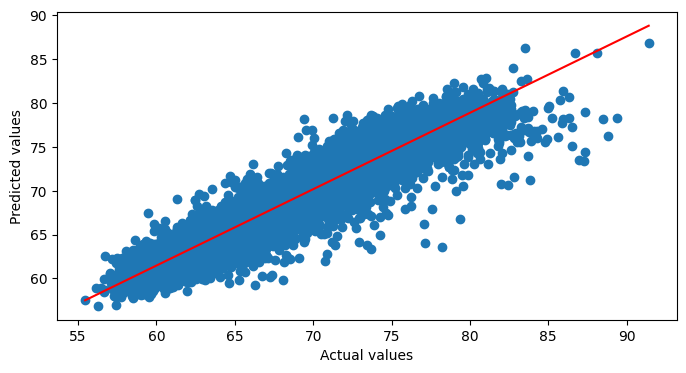

In [22]:
# import libraries for xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# create a xgboost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 1000)

# fit the model
xg_reg.fit(x_train.drop(['LC_RAININ','LC_n','avg_pedestrians','v85','Weather data','LC_WINDDIR','minute','LC_DWPTEMP','LC_HUMIDITY'],axis=1),y_train)

# predict the values
xgb_train_pred = xg_reg.predict(x_train.drop(['LC_RAININ','LC_n','avg_pedestrians','v85','Weather data','LC_WINDDIR','minute','LC_DWPTEMP','LC_HUMIDITY'],axis=1))
xgb_test_pred = xg_reg.predict(x_test.drop(['LC_RAININ','LC_n','avg_pedestrians','v85','Weather data','LC_WINDDIR','minute','LC_DWPTEMP','LC_HUMIDITY'],axis=1))

# show metrics scores for the xgboost model
from sklearn.metrics import r2_score
print('XGBoost')
print('Train R2 score: ',r2_score(y_train,xgb_train_pred))
print('Test R2 score: ',r2_score(y_test,xgb_test_pred))
print('Train RMSE score: ',np.sqrt(mean_squared_error(y_train,xgb_train_pred)))
print('Test RMSE score: ',np.sqrt(mean_squared_error(y_test,xgb_test_pred)))

# create a scatterplot of the predicted values vs the actual values
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,4]
plt.scatter(y_test,xgb_test_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# add the line of best fit
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, xgb_test_pred, 1))(np.unique(y_test)),color='red')
plt.show()

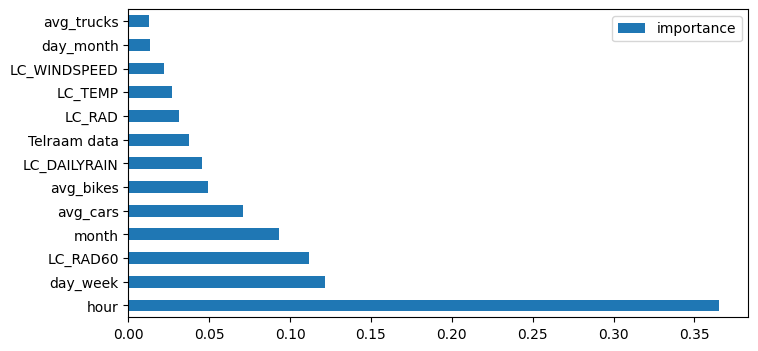

In [23]:
# show feature importance in a horizontal bar chart
feature_importances = pd.DataFrame(xg_reg.feature_importances_,index = x_train.drop(['LC_RAININ','LC_n','avg_pedestrians','v85','Weather data','LC_WINDDIR','minute','LC_DWPTEMP','LC_HUMIDITY'],axis=1).columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot(kind='barh')
plt.show()

Trying with only hour, day_week and month as features

XGBoost
Train R2 score:  0.7394007728865938
Test R2 score:  0.7324860811407168
Train RMSE score:  2.8825217521226234
Test RMSE score:  2.934019672570738


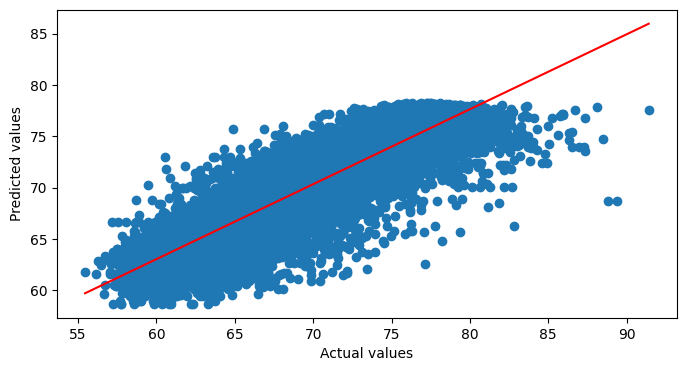

In [26]:
# import libraries for xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# create a xgboost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 1000)

# create x_train_2 with only 'hour','day_week','month'
x_train_2 = x_train[['hour','day_week','month']]
x_test_2 = x_test[['hour','day_week','month']]
# fit the model
xg_reg.fit(x_train_2,y_train)

# predict the values
xgb_train_pred = xg_reg.predict(x_train_2)
xgb_test_pred = xg_reg.predict(x_test_2)

# show metrics scores for the xgboost model
from sklearn.metrics import r2_score
print('XGBoost')
print('Train R2 score: ',r2_score(y_train,xgb_train_pred))
print('Test R2 score: ',r2_score(y_test,xgb_test_pred))
print('Train RMSE score: ',np.sqrt(mean_squared_error(y_train,xgb_train_pred)))
print('Test RMSE score: ',np.sqrt(mean_squared_error(y_test,xgb_test_pred)))

# create a scatterplot of the predicted values vs the actual values
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,4]
plt.scatter(y_test,xgb_test_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# add the line of best fit
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, xgb_test_pred, 1))(np.unique(y_test)),color='red')
plt.show()

### LSTM Implementation ---- Test R2 score:  0.7710763271672757

In [46]:
x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))

Epoch 1/50
1314/1314 [==============================] - 24s 15ms/step - loss: 979.8142
Epoch 2/50
1314/1314 [==============================] - 20s 15ms/step - loss: 70.1841
Epoch 3/50
1314/1314 [==============================] - 20s 15ms/step - loss: 45.1964
Epoch 4/50
1314/1314 [==============================] - 20s 15ms/step - loss: 44.1467
Epoch 5/50
1314/1314 [==============================] - 20s 15ms/step - loss: 42.1416
Epoch 6/50
1314/1314 [==============================] - 20s 15ms/step - loss: 39.8496
Epoch 7/50
1314/1314 [==============================] - 20s 15ms/step - loss: 38.3845
Epoch 8/50
1314/1314 [==============================] - 20s 15ms/step - loss: 37.0839
Epoch 9/50
1314/1314 [==============================] - 20s 15ms/step - loss: 36.2764
Epoch 10/50
1314/1314 [==============================] - 20s 16ms/step - loss: 33.9991
Epoch 11/50
1314/1314 [==============================] - 21s 16ms/step - loss: 27.2076
Epoch 12/50
1314/1314 [============================

ValueError: Polynomial must be 1d only.

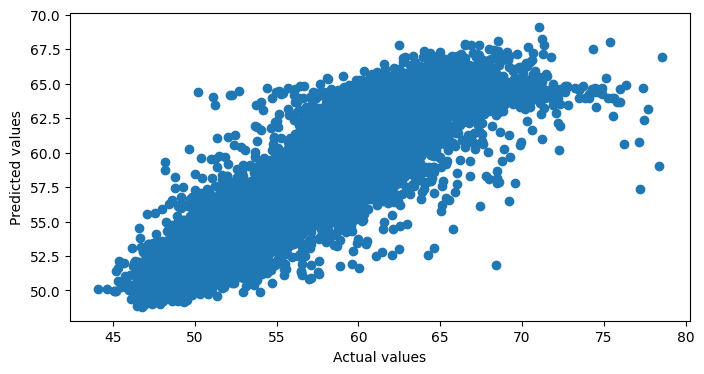

In [74]:
# import libraries for lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# reshape the data
x_train = np.reshape(x_train.values, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test.values, (x_test.shape[0], 1, x_test.shape[1]))

# create a lstm model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

# compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fit the model
model.fit(x_train, y_train, epochs = 50, batch_size = 32)

# predict the values
lstm_train_pred = model.predict(x_train)
lstm_test_pred = model.predict(x_test)

# show metrics scores for the lstm model
print('LSTM')
print('Train R2 score: ',r2_score(y_train,lstm_train_pred))
print('Test R2 score: ',r2_score(y_test,lstm_test_pred))
print('Train RMSE score: ',np.sqrt(mean_squared_error(y_train,lstm_train_pred)))
print('Test RMSE score: ',np.sqrt(mean_squared_error(y_test,lstm_test_pred)))

# create a scatterplot of the predicted values vs the actual values
plt.rcParams['figure.figsize'] = [8,4]
plt.scatter(y_test,lstm_test_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
# add the line of best fit
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, lstm_test_pred, 1))(np.unique(y_test)),color='red')
plt.show()

### Prophet Implementation (Prophet install doesn't work on apple silicon, so here is the link for the online notebook: https://app.datacamp.com/workspace/w/0b7e6a72-68e0-492b-9382-706bc85378a4/edit ) ---- R2 score: 0.7543855615172617

In [4]:
# import libraries for prophet 
from prophet import Prophet
import pandas as pd

Creating the correct format DF for prophet

In [7]:
# create a list with only 2022 values and the length of the dataframe
year_2022 = ['2022'] * len(df)
df['year'] = year_2022
df['month'] = df['month'].astype(str)
df['day'] = df['day_month'].astype(str)
df['hour'] = df['hour'].astype(str)
df['minute'] = df['minute'].astype(str)

# Pad single-digit month, day, hour, and minute values with leading zeros if necessary
df['month'] = df['month'].str.zfill(2)
df['day'] = df['day'].str.zfill(2)
df['hour'] = df['hour'].str.zfill(2)
df['minute'] = df['minute'].str.zfill(2)

# Create 'DS' column by concatenating and formatting year, month, day, hour, and minute columns
df['ds'] = pd.to_datetime(df['year'] + '-' + df['month'] + '-' + df['day'] +
                          ' ' + df['hour'] + ':' + df['minute'] + ':00')

In [8]:
# only keep the DS and lceak_avg columns
df = df[['ds','lcpeak_avg']]
# rename lcpeak_avg to y
df = df.rename(columns={'lcpeak_avg': 'y'})
df.head()

,ds,y
0,2022-01-01 00:00:00,76.1733
1,2022-01-01 00:10:00,70.5935
2,2022-01-01 00:20:00,71.6283
3,2022-01-01 00:30:00,69.4174
4,2022-01-01 00:40:00,66.8824


In [11]:
# save the dataframe to a csv file
df.to_csv('prophet.csv',index=False)

### What if we want to predict when sound is likely to exceed the 70 Decibels barrier ?

In [6]:
df.head()

,month,day_month,day_week,hour,minute,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,...,LC_TEMP,avg_trucks,avg_cars,avg_bikes,avg_pedestrians,v85,Telraam data,Weather data,lceq_avg,lcpeak_avg
0,1,1,6,0,0,0,0.00,0,0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0,0,59.9981,76.1733
1,1,1,6,0,10,91,11.65,38,0,0.0,...,13.14485,0.0,0.0,0.0,0.0,0.0,0,1,55.4889,70.5935
2,1,1,6,0,20,90,11.50,37,0,0.0,...,13.14540,0.0,0.0,0.0,0.0,0.0,0,1,57.2715,71.6283
3,1,1,6,0,30,90,11.50,38,0,0.0,...,13.16009,0.0,0.0,0.0,0.0,0.0,0,1,55.4906,69.4174
4,1,1,6,0,40,90,11.50,37,0,0.0,...,13.14488,0.0,0.0,0.0,0.0,0.0,0,1,53.9855,66.8824


In [73]:
# how many times is lcpeak_avg > 70
df[df['lceq_avg'] > 70].count()[0]/df.count()[0]
# how many times is lcpeak_avg > 80
df[df['lcpeak_avg'] > 75].count()[0]/df.count()[0]

0.3029749329069834

In [74]:
df_binary=df.copy()
df_binary['lcpeak_avg'] = np.where(df_binary['lcpeak_avg'] > 75, 1, 0)
df_binary['lceq_avg']= np.where(df_binary['lceq_avg'] > 70, 1, 0)

In [20]:
df_binary.head()

,month,day_month,day_week,hour,minute,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,...,LC_TEMP,avg_trucks,avg_cars,avg_bikes,avg_pedestrians,v85,Telraam data,Weather data,lceq_avg,lcpeak_avg
0,1,1,6,0,0,0,0.00,0,0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,1,1,6,0,10,91,11.65,38,0,0.0,...,13.14485,0.0,0.0,0.0,0.0,0.0,0,1,0,0
2,1,1,6,0,20,90,11.50,37,0,0.0,...,13.14540,0.0,0.0,0.0,0.0,0.0,0,1,0,0
3,1,1,6,0,30,90,11.50,38,0,0.0,...,13.16009,0.0,0.0,0.0,0.0,0.0,0,1,0,0
4,1,1,6,0,40,90,11.50,37,0,0.0,...,13.14488,0.0,0.0,0.0,0.0,0.0,0,1,0,0


In [75]:
# split into training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_binary.drop(['lceq_avg','lcpeak_avg'],axis=1), df_binary['lcpeak_avg'], test_size=0.2, random_state=40)

#### Gradient Boosting Classifier

In [ ]:
# perform random search to find the best parameters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
random_grid = {'n_estimators': [100, 500, 1000],
                'max_depth': [3, 5, 10, 15, 20],
                'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1],
                'alpha': [0, 5, 10, 15, 20]}
xgb_model = xgb.XGBClassifier(objective ='binary:logistic')
xgb_random = RandomizedSearchCV(estimator = xgb_model, param_distributions = random_grid, n_iter = 30, cv = 5, verbose=2, random_state=40, n_jobs = -1)
# show the best parameters
xgb_random.fit(x_train,y_train)
xgb_random.best_params_

XGBoost
Train accuracy score:  0.9205824272560729
Test accuracy score:  0.8682908260373049
Train precision score:  0.8097027222991233
Test precision score:  0.7311745052685685
Sensitivity:  0.8938108702481935
Specificity:  0.8572013651877133


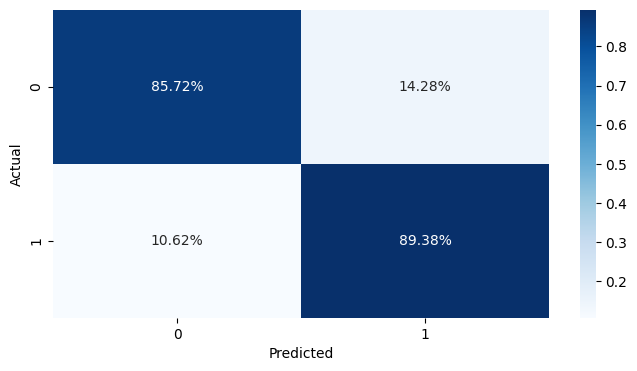

In [78]:
# import libraries for xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# create a xgboost model for binary classification
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.5, learning_rate = 0.01,
                max_depth = 20, alpha = 5, n_estimators = 1000)

# fit the model
xg_reg.fit(x_train,y_train)

# predict the probabilities of 1 and adjust the threshold to 0.3
xgb_train_pred = xg_reg.predict_proba(x_train)[:,1]
xgb_train_pred = np.where(xgb_train_pred > 0.3, 1, 0)
xgb_test_pred = xg_reg.predict_proba(x_test)[:,1]
xgb_test_pred = np.where(xgb_test_pred > 0.3, 1, 0)

# show performance for the classification model
print('XGBoost')
print('Train accuracy score: ',accuracy_score(y_train,xgb_train_pred))
print('Test accuracy score: ',accuracy_score(y_test,xgb_test_pred))
print('Train precision score: ',precision_score(y_train,xgb_train_pred))
print('Test precision score: ',precision_score(y_test,xgb_test_pred))

# show sensitivity and specificity
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test,xgb_test_pred).ravel()
print('Sensitivity: ',tp/(tp+fn))
print('Specificity: ',tn/(tn+fp))

# show the confusion matrix as a heatmap using percentages wih x and y labels
import seaborn as sns
cm = confusion_matrix(y_test,xgb_test_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

This is nice but the problem is that we have a higly imbalanced dataset, so we are predicting a lot of false positives.